In [1]:
import os
import tarfile
from six.moves import urllib

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
# get the dataset
fetch_housing_data()

In [5]:
import pandas as pd

In [6]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [7]:
# load housing data into pandas
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
# get a quick description of the data
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
# to find out what categories exist
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [10]:
# summary of the numerical attribute
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


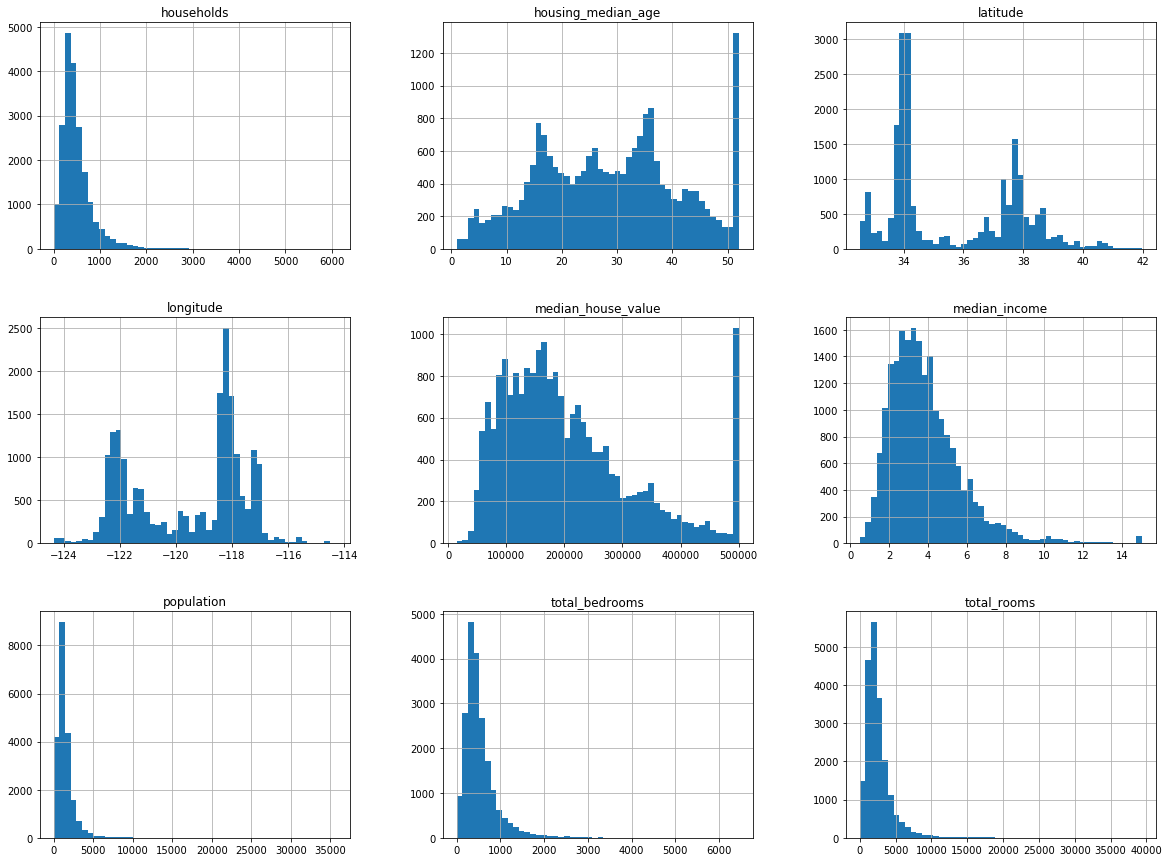

In [11]:
# plot histogram for each numerical attribute
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()

In [12]:
# Create a test set
import numpy as np

# manual
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set))
print(len(test_set))

# it has a weakness, when we run again, it will generate a different test set
# we can use np.random.seed(30), but when dataset updated will break

16512
4128


In [13]:
# the solution is we could compute a hash of each instances's identifier

from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index() # add column name 'index'
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

print(len(train_set))
print(len(test_set))

16512
4128


In [14]:
# we could replace hash with unique features, example: latitude and longitude
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

print(len(train_set))
print(len(test_set))

16322
4318


In [15]:
# we could use useful library scikit-learn train_test_split
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

print(len(train_set))
print(len(test_set))

16512
4128


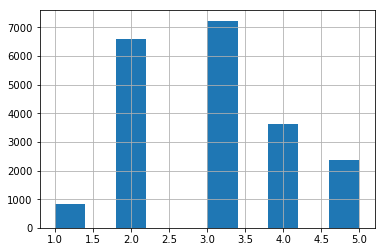

In [16]:
# we should maintain the ratio for the samples
# example: US population is composed of 51.3% female and 48.7% male
# so we must to keep maintain the ratio, for example 513 female and 487 male
# it is called Stratified Sampling: population is divided into homogeneous subgroups
# if we could not maintain the ratio, the results will be biased

# so, in our case in housing dataset, in median income is a continous numerical attribute
# we need to look closely, most median incomes values are clustered around 2 to 5
# and some median incomes go far beyond 6, we can stratified it
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

housing["income_cat"].hist()

In [17]:
# we can use scikit-learn StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
# let's see income category proportions in the test set
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [18]:
# lets compare with overall and random
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

compare_props

# as you can see, the test set generated using stratified sampling 
# has income category proportions almost indentical to those in the full dataset

,Overall,Stratified,Random,Rand. %error,Strat. %error
1.0,0.039826,0.039729,0.040213,0.973236,-0.243309
2.0,0.318847,0.318798,0.324370,1.732260,-0.015195
3.0,0.350581,0.350533,0.358527,2.266446,-0.013820
4.0,0.176308,0.176357,0.167393,-5.056334,0.027480
5.0,0.114438,0.114583,0.109496,-4.318374,0.127011


In [19]:
# now, lets make the data back to its original by removing income_cat
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Discover and Visualize the Data to Gain Insights

In [20]:
# we make a copy in training set, so it will not affect the original
housing = strat_train_set.copy()

### Visualizing Geographical Data

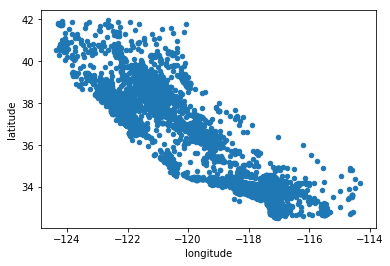

In [21]:
# scatter plot
housing.plot(kind="scatter", x="longitude", y="latitude")

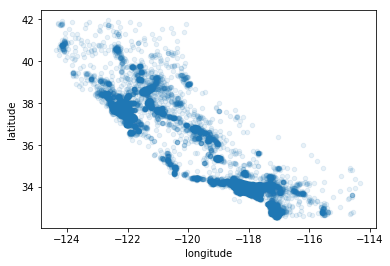

In [22]:
# we can set the alpha, so it much easier to notice place with high density
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

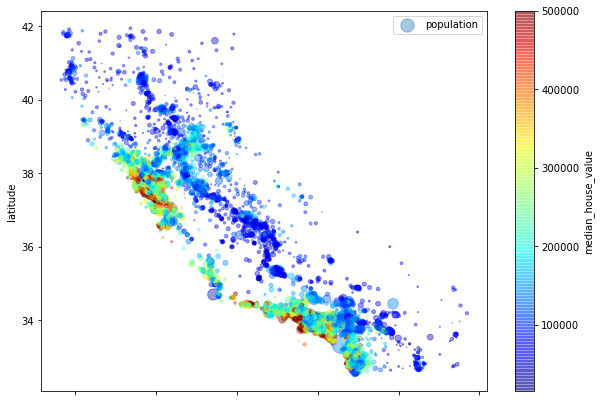

In [23]:
# using color map for the median house values
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

# the housing prices related to the population density

## Looking for Correlations

In [24]:
# using standard correlation coefficient called Pearson
corr_matrix = housing.corr()

# let's look how much each attribute correlates with median house value
corr_matrix["median_house_value"].sort_values(ascending=False)

# correlation coefficient between -1 to 1
# when it is close to 1, it means that there is a strong positive correlation
# otherwise, it has a strong negative correlation

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CBD273FDA0>,
      dtype=object)

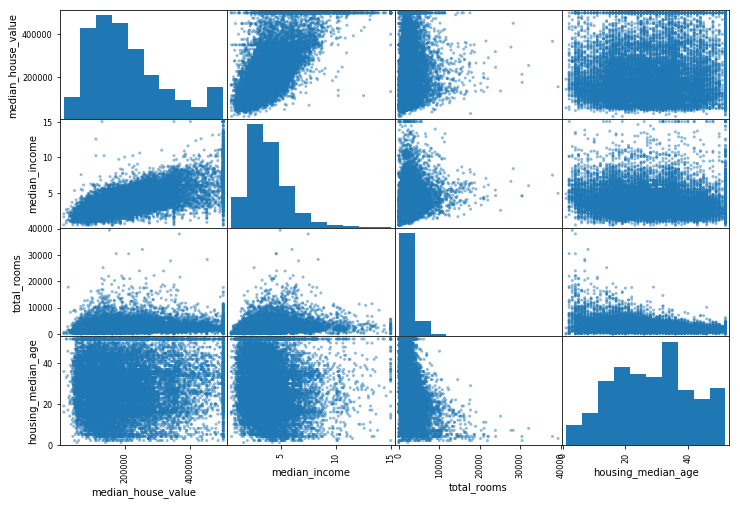

In [25]:
# another way to check correlation, using Panda's scatter_matrix
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

# if variables against itself, which would not be very useful, it will show histogram

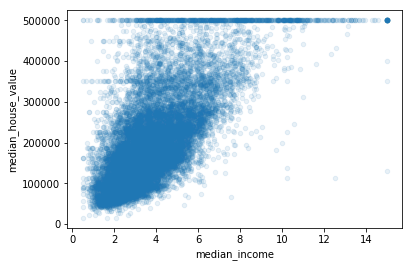

In [26]:
# the most promising attribute to predict the median house value is median income
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)

### Experimenting with Attribute Combinations

In [27]:
# we could combine attibutes that are not very useful

# combine total_rooms with households, so we get rooms_per_household
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]

# combine total_bedrooms with total_rooms, so we get bedrooms_per_room
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]

# combine population with household, so we get population_per_household
housing["population_per_household"] = housing["population"]/housing["households"]

In [28]:
# let's take a look again the correlation matrix
coor_matrix = housing.corr()
coor_matrix["median_house_value"].sort_values(ascending=False)

# not so bad, bedrooms_per_room is much more correlated than total_rooms

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

# Prepare the Data for Machine Learning Algorithm

In [29]:
# create a copy again, them drop the target values
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Data Cleaning

In [30]:
# most ML algorithms cannot work with missing features

# first solution: drop the missing data
housing.dropna(subset=["total_bedrooms"])

# second solution: drop the whole attribute
housing.drop("total_bedrooms", axis=1)

# third solution: fill the missing data with zero/mean/median/etc
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

In [31]:
# scikit-learn have imputer that will help us the most
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

# since, the median can only be computed in numerical attributes
housing_num = housing.drop("ocean_proximity", axis=1)

imputer.fit(housing_num)

# the imputer has simply computed the median for each attribute
print(imputer.statistics_)
print(housing_num.median().values)

[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


In [32]:
# now, we transform the training set by replacing missing values with medians
X = imputer.transform(housing_num)

# since the result is a numpy array, we can put it back into pandas dataframe
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

## Handling Text and Categorical Attributes

In [33]:
# we have one categorical types column
housing_cat = housing["ocean_proximity"]
housing_cat.head()

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
Name: ocean_proximity, dtype: object

In [34]:
# convert from text to numbers with Pandas's factorize
housing_cat_encoded, housing_categories = housing_cat.factorize()
print(housing_cat_encoded[:5])

# it will map into number, '<1H OCEAN' to 0, 'NEAR OCEAN' to 1, etc
print(housing_categories)

# it has an issue, for example, categories 0 and 4 are more similar tha categories 0 and 2

[0 0 1 2 0]
Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')


In [35]:
# to fix this, we could use one-hot-encoding, it will create one binary attribute per category
# only one attribute will be equal 1 (hot), while the others will be 0 (cold)
# scikit-learn provide the library OneHotEncoder
# from sklearn.preprocessing import OneHotEncoder
from future_encoders import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
print(housing_cat_1hot[:5])

# it will produce sparse matrix instead of numpy array, we can convert it
# print(housing_cat_1hot.toarray())

# TIPS: if categorical attributes has a large number of possible categories
# the one-hot-encoding will result in a large number of input features, it will degrade the performance
# so, we need produce denser representations called embeddings

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]


## Custom Transformers

In [36]:
# scikit-learn already provides many useful transformers
# but we need to write our own for example in custom cleanup operations or combining specific attributes
# for example, here is a transformer that adds the combined attributes
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

# the more we automate data preparation steps, the more combinations we can automatically try out
# and saving a lot of time

## Feature Scaling

In [37]:
# ML algorithms don't perform well when the input numerical attributes have very different scales
# there are two common ways

# first: MinMaxScaler
# values are shifted and rescaled so that they end up ranging from 0 to 1

# second: Standardization (StandardScaler)
# it subtracts the mean value (so standardized values have a zero mean), 
# then it divides by the standard deviation so that the resulting distribution has unit variance

## Transformation Pipelines

In [38]:
# scikit-learn provide the Pipeline class to help sequences of transformations
# All but the last estimator must be transformers (they must have a fit_transform method)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [39]:
# we gonna use ColumnTransformer from future_encoders for categorical data
from future_encoders import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape

(16512, 16)

# Select and Train a Model

In [40]:
# linear regression
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [41]:
# let's make a prediction, try our training set
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [42]:
# we can evaluate regression models with mean squared error
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

# we get an error around $68000, so our model is not good enough
# we need to regularize the model

68628.19819848923

In [43]:
# use decision tree regressor
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

# evaluate
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

# we get 0 error, is it good enough? No! it is called overfitting

0.0

## Better Evaluation Using Cross-Validation

In [44]:
# let's use scikit-learn library cross_val_score
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

# display scores
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())
    
display_scores(tree_rmse_scores)

# the rmse score perform worse than linear regression with $71000 error

Scores: [68015.14074808 67961.22231498 69998.40911086 68160.65541067
 72902.20356643 74739.11665017 70190.19801363 71679.5252332
 75908.13931308 69548.89142559]
Mean: 70910.35017866854
Standard Deviation: 2684.0398435376833


In [45]:
# try compute cross_val_score on linear regression
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

# the result Linear Regression still perform better than Decision Tree

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard Deviation: 2731.6740017983466


In [46]:
# try compute with RandomForestRegressor
# building a model on top of many other models is called Ensemble Learning
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

# evaluate
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

# the result is better than the others

C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Scores: [52654.30489132 50704.13224909 52299.30085737 55061.74558327
 52365.18033706 55881.5398498  50582.86972326 50184.7713757
 54987.9886437  52095.79710889]
Mean: 52681.76306194639
Standard Deviation: 1906.9221561737388


# Fine-Tune Your Model

## Grid Search

In [47]:
# with Grid Search, we could try all the possible combinations of hyperparameter values
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 7]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid,cv=5,
                           scoring="neg_mean_squared_error")
grid_search.fit(housing_prepared, housing_labels)

# best hyperparameter params
print(grid_search.best_params_)

# we could also get the best estimator directly
print(grid_search.best_estimator_)

{'max_features': 7, 'n_estimators': 30}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


In [48]:
# and also we get evaluation scores
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
    
# we know the best hyperparameters {'max_features': 7, 'n_estimators': 30}
# the result is improving from $52K to $50K

64669.726225248014 {'max_features': 2, 'n_estimators': 3}
55407.941003088934 {'max_features': 2, 'n_estimators': 10}
52926.08280135884 {'max_features': 2, 'n_estimators': 30}
59282.103923108356 {'max_features': 4, 'n_estimators': 3}
52884.77868818957 {'max_features': 4, 'n_estimators': 10}
50242.98255428336 {'max_features': 4, 'n_estimators': 30}
59665.10108190908 {'max_features': 6, 'n_estimators': 3}
51835.38018763639 {'max_features': 6, 'n_estimators': 10}
50200.85319870628 {'max_features': 6, 'n_estimators': 30}
59216.77162416882 {'max_features': 7, 'n_estimators': 3}
52422.59348764034 {'max_features': 7, 'n_estimators': 10}
50041.75526144702 {'max_features': 7, 'n_estimators': 30}
62863.35812685079 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54334.74430119712 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60269.31184505225 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52830.24179986058 {'bootstrap': False, 'max_features': 3, 'n_estimators':

## Randomized Search

In [49]:
# when the hyperparameter search space is large, it is prefer to use RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001CBE1FDA4A8>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001CBE1FDA9B0>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [50]:
# evaluation scores
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49147.15241724505 {'max_features': 7, 'n_estimators': 180}
51396.876896929905 {'max_features': 5, 'n_estimators': 15}
50797.05737322649 {'max_features': 3, 'n_estimators': 72}
50840.744513982805 {'max_features': 5, 'n_estimators': 21}
49276.17530332962 {'max_features': 7, 'n_estimators': 122}
50775.46331678437 {'max_features': 3, 'n_estimators': 75}
50681.383924974936 {'max_features': 3, 'n_estimators': 88}
49612.152530468346 {'max_features': 5, 'n_estimators': 100}
50473.01751424941 {'max_features': 3, 'n_estimators': 150}
64458.25385034794 {'max_features': 5, 'n_estimators': 2}


## Analyze the Best Models and Their Errors

In [51]:
# we can indicate the relative importance of each attribute for making accurate predictions
feature_importances = grid_search.best_estimator_.feature_importances_
print(feature_importances)

# let's try with extra attributes
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_hhold"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
print(sorted(zip(feature_importances, attributes), reverse=True))

# with this information, we could dropping some of the less useful features

[6.75864853e-02 6.33323841e-02 4.43251788e-02 1.67533683e-02
 1.53350754e-02 1.66086757e-02 1.51030237e-02 3.64429557e-01
 4.99370320e-02 1.14885790e-01 7.72959492e-02 6.95560786e-03
 1.41097573e-01 8.62560302e-05 2.29342642e-03 3.97461608e-03]
[(0.364429557281257, 'median_income'), (0.1410975734217823, 'INLAND'), (0.11488579041504113, 'pop_per_hhold'), (0.07729594916096076, 'bedrooms_per_hhold'), (0.06758648533427093, 'longitude'), (0.06333238407301868, 'latitude'), (0.0499370320474961, 'rooms_per_hhold'), (0.044325178765552246, 'housing_median_age'), (0.016753368322907563, 'total_rooms'), (0.016608675684292844, 'population'), (0.015335075445285774, 'total_bedrooms'), (0.015103023652739142, 'households'), (0.006955607860554419, '<1H OCEAN'), (0.003974616083361879, 'NEAR OCEAN'), (0.002293426421315692, 'NEAR BAY'), (8.625603016353944e-05, 'ISLAND')]


## Evaluate Your System on the Test Set

In [52]:
# get the best model
final_model = grid_search.best_estimator_

# drop the target/labels
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# data preparation
X_test_prepared = full_pipeline.transform(X_test)

# predict
final_predictions = final_model.predict(X_test_prepared)

# evaluate
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

48302.826175521026


# Launch, Monitor, and Maintain Your System

We also need to write monitoring code to check system live perfomance at regular intervals and trigger alerts when it drops

# Exercises

1. Try a Support Vector Machine regressor (sklearn.svm.SVR), with various hyperparameters such as kernel="linear" (with various values for the C hyperparameter) or kernel="rbf" (with various values for the C and gamma hyperparameters). Don’t worry about what these hyperparameters mean for now. How does the best SVR predictor perform?

In [53]:
from sklearn.svm import SVR

param_grid = [
    {'kernel': ['linear'], 'C': [10, 50, 100, 150, 200, 1000, 5000, 10000, 50000]},
    {'kernel': ['rbf'], 'C': [1, 5, 10, 50, 100, 500, 1000, 5000],
     'gamma': [0.01, 0.05, 0.1, 0.5, 1, 5]}
]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'kernel': ['linear'], 'C': [10, 50, 100, 150, 200, 1000, 5000, 10000, 50000]}, {'kernel': ['rbf'], 'C': [1, 5, 10, 50, 100, 500, 1000, 5000], 'gamma': [0.01, 0.05, 0.1, 0.5, 1, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [54]:
# rmse score
neg_mse = grid_search.best_score_
rmse = np.sqrt(-neg_mse)
print(rmse)

# best params
print("Best parameters:", grid_search.best_params_)

63116.85828296859
Best parameters: {'C': 5000, 'gamma': 0.1, 'kernel': 'rbf'}


2. Try replacing GridSearchCV with RandomizedSearchCV.

In [55]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

param_distribs = {
    'kernel': ['linear', 'rbf'],
    'C': reciprocal(20, 200000),
    'gamma': expon(scale=1.0)
}

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring="neg_mean_squared_error",
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 33.9min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 48.9min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=4,
          param_distributions={'kernel': ['linear', 'rbf'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001CBE21B3DA0>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001CBE21B38D0>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

In [56]:
# best model
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

54767.99053704408

In [57]:
# best params
rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

3. Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [58]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    
    def transform(self, X):
        return X[:, self.feature_indices_]

In [59]:
# define number of top faetures
k = 5

In [60]:
# look for indices of the top k features
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  7,  9, 10, 12], dtype=int64)

In [61]:
# see the attributes
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'median_income', 'pop_per_hhold',
       'bedrooms_per_hhold', 'INLAND'], dtype='<U18')

In [62]:
# combine the arrays
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.364429557281257, 'median_income'),
 (0.1410975734217823, 'INLAND'),
 (0.11488579041504113, 'pop_per_hhold'),
 (0.07729594916096076, 'bedrooms_per_hhold'),
 (0.06758648533427093, 'longitude')]

In [63]:
# create the pipeline
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [64]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

In [65]:
# look at the features
housing_prepared_top_k_features[:3]

array([[-1.15604281, -0.61493744, -0.08649871,  0.15531753,  0.        ],
       [-1.17602483,  1.33645936, -0.03353391, -0.83628902,  0.        ],
       [ 1.18684903, -0.5320456 , -0.09240499,  0.4222004 ,  0.        ]])

In [66]:
# double check with the origin preparation
housing_prepared[0:3, top_k_feature_indices]

# and the result same with the above

array([[-1.15604281, -0.61493744, -0.08649871,  0.15531753,  0.        ],
       [-1.17602483,  1.33645936, -0.03353391, -0.83628902,  0.        ],
       [ 1.18684903, -0.5320456 , -0.09240499,  0.4222004 ,  0.        ]])

4. Try creating a single pipeline that does the full data preparation plus the final prediction.

In [67]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [68]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
     steps=[('preparation', ColumnTransformer(n_jobs=1, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('attribs_adder'... gamma=0.26497040005002437, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))])

In [69]:
# try on a few data
few_data = housing.iloc[:5]
few_labels = housing_labels.iloc[:5]

print("Predictions:", prepare_select_and_predict_pipeline.predict(few_data))
print("Labels:", list(some_labels))

Predictions: [185384.13066634 341000.56131537 172531.39955817  56040.55006167
 200466.24743222]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


5. Automatically explore some preparation options using GridSearchCV

In [70]:
# using grid search cv
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)

# do the grid search
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   8.6s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.6s remaining:    0.0s


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   8.4s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   8.2s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   8.2s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   8.1s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=   8.1s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=   8.1s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__

[CV]  feature_selection__k=4, preparation__num__imputer__strategy=median, total=   8.9s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=median, total=   8.9s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=median, total=  12.2s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=most_frequent, total=  10.9s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=most_frequent, total=  12.6s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=most_frequent, total=   9.6s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=

[CV]  feature_selection__k=7, preparation__num__imputer__strategy=most_frequent, total=  11.8s
[CV] feature_selection__k=7, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=7, preparation__num__imputer__strategy=most_frequent, total=  12.9s
[CV] feature_selection__k=7, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=7, preparation__num__imputer__strategy=most_frequent, total=  11.7s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=8, preparation__num__imputer__strategy=mean, total=  13.1s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=8, preparation__num__imputer__strategy=mean, total=  12.8s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=8, preparation__num__imputer__strategy=mean, total=  13.8s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature

[CV]  feature_selection__k=11, preparation__num__imputer__strategy=mean, total=  23.7s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=mean, total=  25.3s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=mean, total=  22.9s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  21.8s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  21.7s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  24.3s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, p

[CV]  feature_selection__k=14, preparation__num__imputer__strategy=median, total=  29.0s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=median, total=  29.2s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=median, total=  31.3s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=most_frequent, total=  29.5s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=most_frequent, total=  31.4s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=most_frequent, total=  28.9s
[CV] feature_selection__k=14, preparation__num__impute

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 91.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('preparation', ColumnTransformer(n_jobs=1, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('attribs_adder'... gamma=0.26497040005002437, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'], 'feature_selection__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [71]:
# best params
grid_search_prep.best_params_

{'feature_selection__k': 15, 'preparation__num__imputer__strategy': 'mean'}